In [28]:
import pandas as pd          # for extracting and manipulating data from dataset
import numpy as np           # for mathematical calculations
import matplotlib.pyplot as plt    # for plotting graphs
from datetime import datetime      # to access datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline                
import warnings                    #  to ignore warnings
warnings.filterwarnings("ignore")

#reading train and test data
train = pd.read_csv ('C:/Users/gaura/Documents/Projects/Python Projects/Time series/Train data.csv')
test = pd.read_csv('C:/Users/gaura/Documents/Projects/Python Projects/Time series/Test data.csv')

#We make a copy of the data so that we do not lose the original data even after changes
train_original = train.copy()
test_original = test.copy()


# diving deeper in dataset 
train.columns, test.columns        # features in train and test


(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [4]:
train.shape, test.shape       # dimensions of train and test

((18288, 3), (5112, 2))

Test data has one less feature which is the target variable count of passengers corresponding to each datetime

In [23]:
print(train.dtypes, test.dtypes)      # data tyoes of each feature

train.head()   #first 5 rows of data

ID              float64
Count           float64
year            float64
month           float64
day             float64
Hour            float64
day of week     float64
weekend         float64
dtype: object ID       float64
year     float64
month    float64
day      float64
Hour     float64
dtype: object


,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


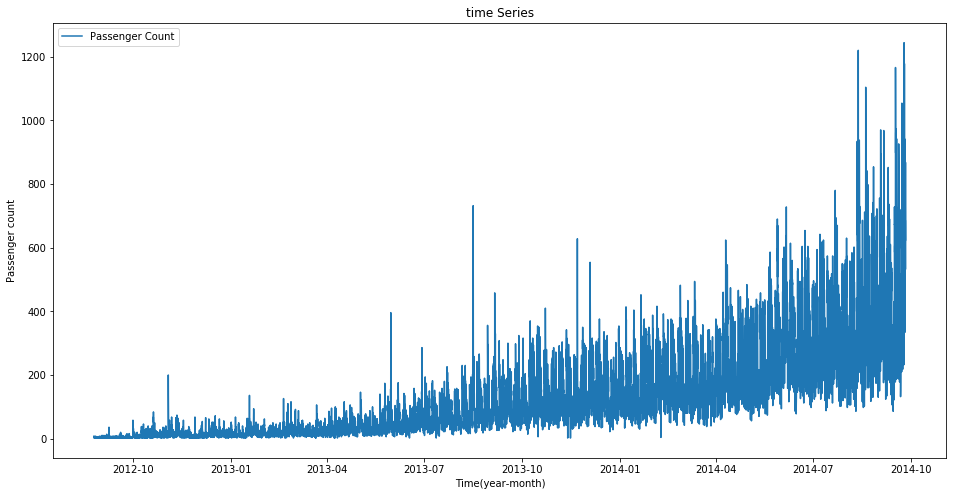

In [6]:
# Changing the object of Datetime in train and test data to 'datetime' to extract features from it
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(test_original.Datetime, format= '%d-%m-%Y %H:%M')
test_original ['Datetime'] = pd.to_datetime(test_original.Datetime, format= '%d-%m-%Y %H:%M')

# To extract the year, month, day and hour to make further analysis
for i in (train, test, test_original, train_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour
    
#To generate weekend and weekday variables
train['day of week '] = train['Datetime'].dt.dayofweek
temp = train ['Datetime']

#We assign 1 if the day of week is weekend and 0 if the day of week is weekday
def applyer(row):
    if row.dayofweek==5 or row.dayofweek == 6:
        return 1
    else:
        return 0
    
train['weekend'] = train ['Datetime'].apply(applyer)

#assigning index as Datetime to get the time period on x-axis.
train.index = train['Datetime']
df = train.drop('ID',1)
ts= train.Count
plt.figure(figsize=(16,8))
plt.plot(ts, label = 'Passenger Count')
plt.title ('time Series')
plt.xlabel('Time(year-month)')
plt.ylabel ('Passenger count')
plt.legend(loc = 'best')

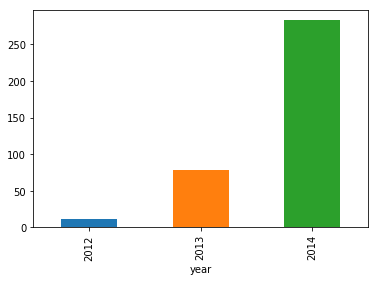

In [7]:
#General trend is increase in passenger count with increase in time. Next we do EXPLORATORY ANALYSIS

#To check yearly passenger count
train.groupby('year')['Count'].mean().plot.bar()

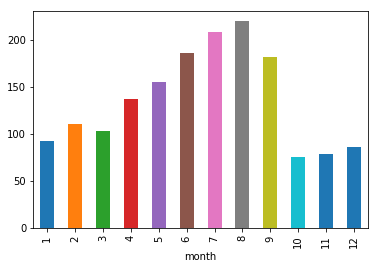

In [8]:
# Passenger count increase exponentially with increase in years. Let's check for months.

train.groupby('month')['Count'].mean().plot.bar()

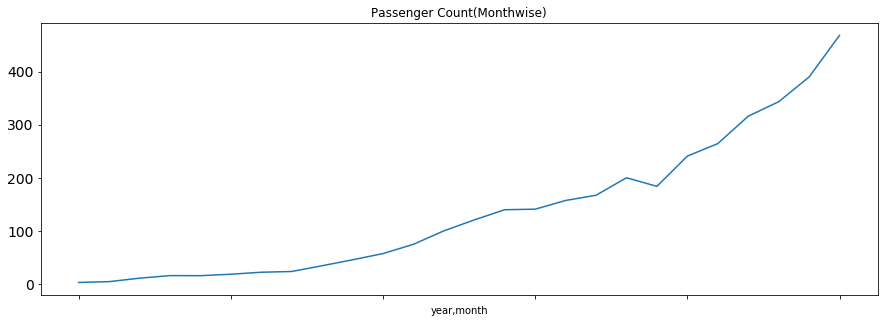

In [9]:
# we see a monthly decrease in the mean of passenger count in last three months
temp  = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15,5), title = 'Passenger Count(Monthwise)', fontsize = 14)

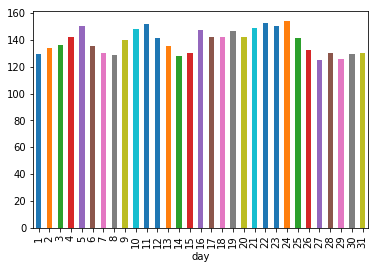

In [12]:
#Year 2014 does not has last three months that is the reason we are getting less counts for these months
train.groupby('day')['Count'].mean().plot.bar()

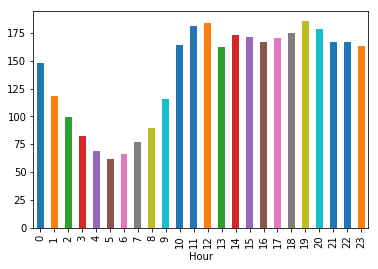

In [10]:
#not much insights available from day wise counts. Let's check the mean of hourly passenger count
train.groupby('Hour')['Count'].mean().plot.bar()

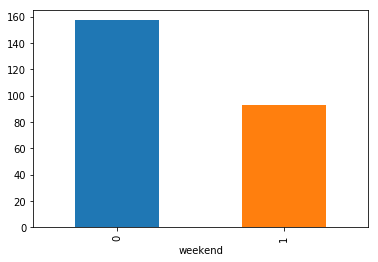

In [11]:
#Peak traffic os at 7 pm and then it decreases till 5 am. Let's check the traffic trend for weekends.
train.groupby('weekend')['Count'].mean().plot.bar()

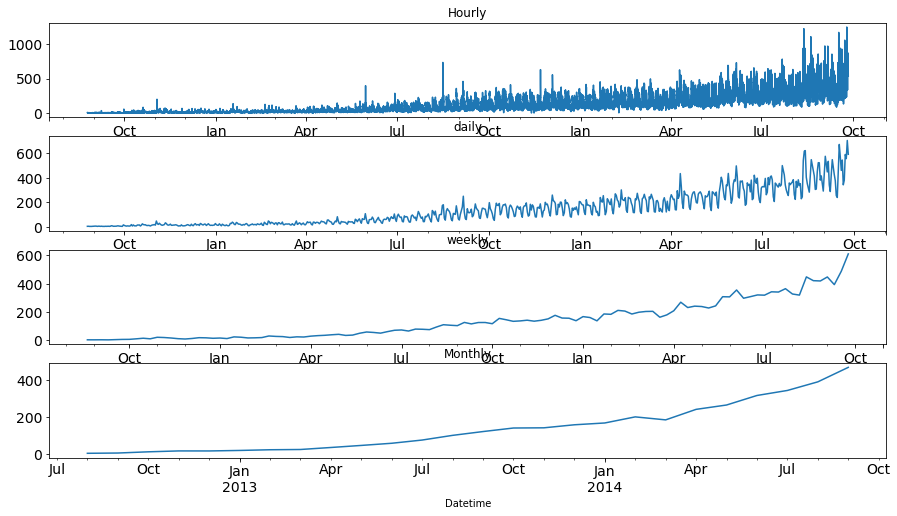

In [13]:
#Clearly traffic is more on weekdays than weekends.
# Before oving forward to modelling we have to drop the ID variable as it has got nothing to do with passenger count


# We aggregate hourly time series to daily, weekly and monthly to reduce the noise and make it more stable for model to learn
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

fig,ax = plt.subplots(4,1)
hourly.Count.plot(figsize= (15,8), title = 'Hourly', fontsize= 14, ax = ax[0])
daily.Count.plot(figsize=(15,8), title = 'daily', fontsize= 14, ax=ax [1])
weekly.Count.plot(figsize=(15,8), title = 'weekly', fontsize = 14, ax = ax [2])
monthly.Count.plot(figsize=(15,8), title = 'Monthly', fontsize= 14, ax = ax [3])

plt.show()


We can see that the time series is becoming more and more stable. So we will work with the daily time series

In [14]:
# We can see that the time series is becoming more and more stable. So we will work with the daily time series

test.Timestamp = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()


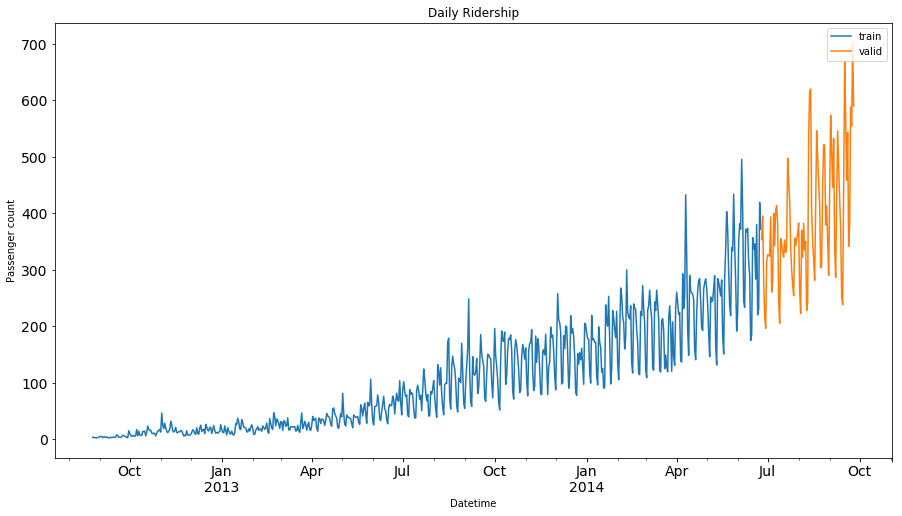

In [22]:
# Splitting the data into training and Validation. We take last 3 months as our validation data and rest as training data

Train = train.ix['2012-08-25' : '2014-06-24']
valid = train.ix['2014-06-25' : '2014-09-25']

Train.Count.plot(label = 'train')
valid.Count.plot(figsize= (15,8), title = 'Daily Ridership', fontsize = 14 , label = 'valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc = 'upper right')
plt.show()

Blue part reperesents the training data and orange part is validating data. Next we look at the different modelling techniques for forecasting.


**1) Naive Approach**- In this approach we assume that the next expected point is equal to the last observed point

Text(0.5, 1.0, 'Naive Forecast')

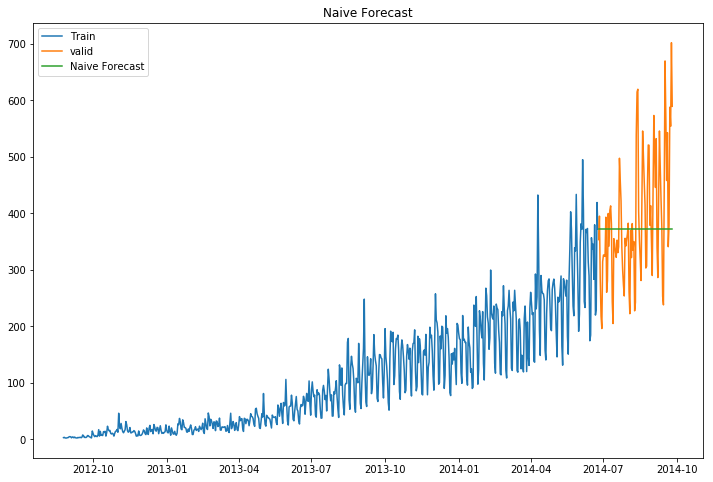

In [27]:
dd = np.asarray(Train.Count)        # to convert the train to array
y_hat = valid.copy()                # copy of validation set
y_hat['naive'] = dd[len(dd)-1]      # new column for naive forecasted values all equal to the last value of train data
plt.figure (figsize=(12,8))
plt.plot(Train.index, Train['Count'], label = 'Train')
plt.plot(valid.index, valid['Count'], label = 'valid')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend (loc= 'best')
plt.title('Naive Forecast')

We compute the accuracy of our using Root Mean Squared Error (RMSE) on the validation set

In [30]:
from math import sqrt
rms= sqrt(mean_squared_error(valid.Count, y_hat.naive))
print (rms)

111.79050467496724


We can tell intuitively that this error value can be reduced using better algorithms

**2) Moving Average** - In this technique we take the average of the passenger counts for last few time periods only

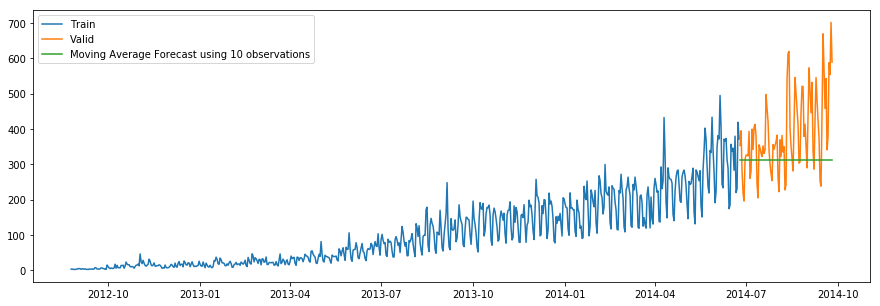

RMSE=  134.23733308950264


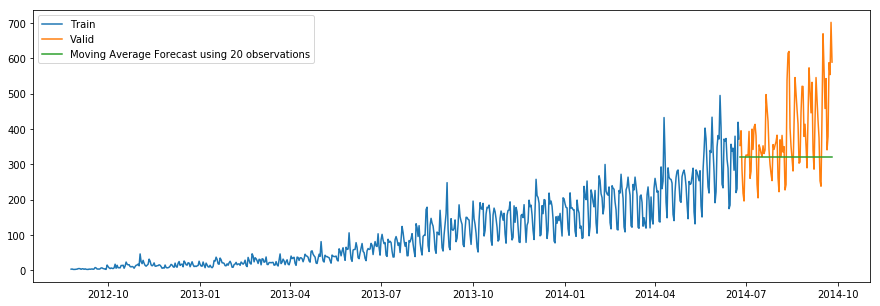

RMSE=  130.44984977550422


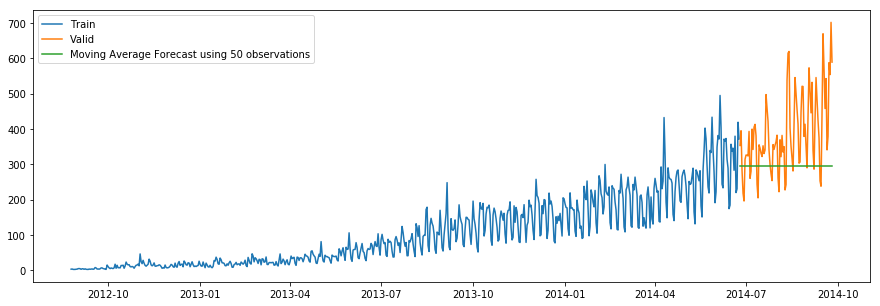

RMSE=  144.19175679986802


In [32]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))

We see that the errors are increasing that means the predictions are getting weaker with increasing the rolling observations.

**3) Simple Exponential Smoothing** - In this technique we assign larger weights to more recent observations than to observations from the distant past. The weights reduce exponentially from recent to oldest observations

RMSE =  113.43708111884514


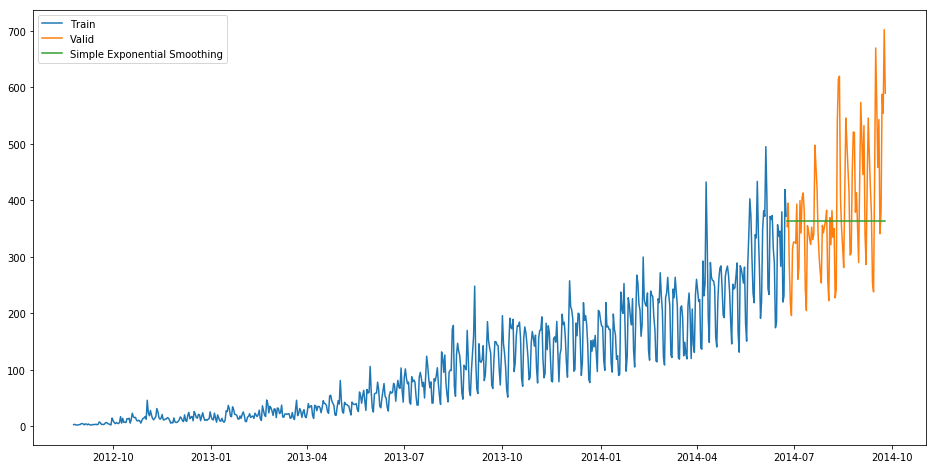

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level = 0.6, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SES'], label = 'Simple Exponential Smoothing')
plt.legend(loc ='best')
print('RMSE = ', sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)))

RMSE is lower than moving average method. <br>
<br>
**4) Holt's linear trend model**- It is an extension pf exponential method to allow forecasting of data with a trend. The algortihm is a function of level and trend.<br>First of all let us visualize the trend, seasonality and error in the series.<br>

We can decompose the time series in four parts.

1) Observed, which is the original time series.<br>
2) Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.<br>
3) Seasonal, which tells us about the seasonality in the time series.<br>
4) Residual, which is obtained by removing any trend or seasonality in the time series.<br>


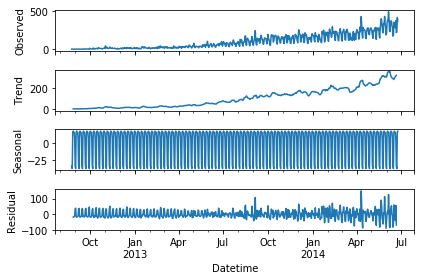

In [43]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
resut = sm.tsa.stattools.adfuller(train.Count)
plt.show()

We can see that the trend is increasing so lets forecast the passenger count based on Holt's method.

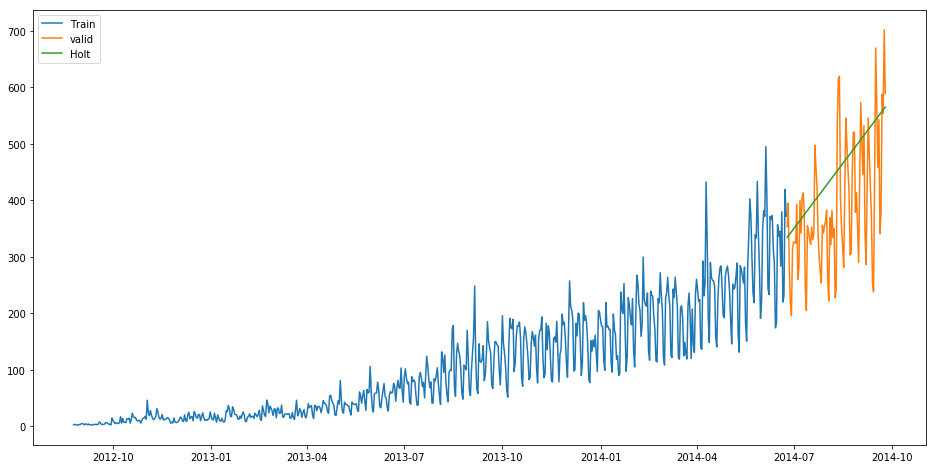

RMSE =  112.94278345314041


In [48]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train.Count)).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train.Count, label = 'Train')
plt.plot(valid.Count, label = 'valid')
plt.plot(y_hat_avg.Holt, label = 'Holt')
plt.legend(loc = 'best')
plt.show()
print('RMSE = ', sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt)))

We see that the RMSE value has further decreased from Simple Exponential Smoothing. Let's apply Holt Winter's model.<br> <br>
**4) Holt Winter's model on daily time series** - For datasets which show a similar set of patterns after fixed intervals of time or seasonality which the earlier models didn't take into account. Holt Winter's method applies seasonality in addition to level and trend.


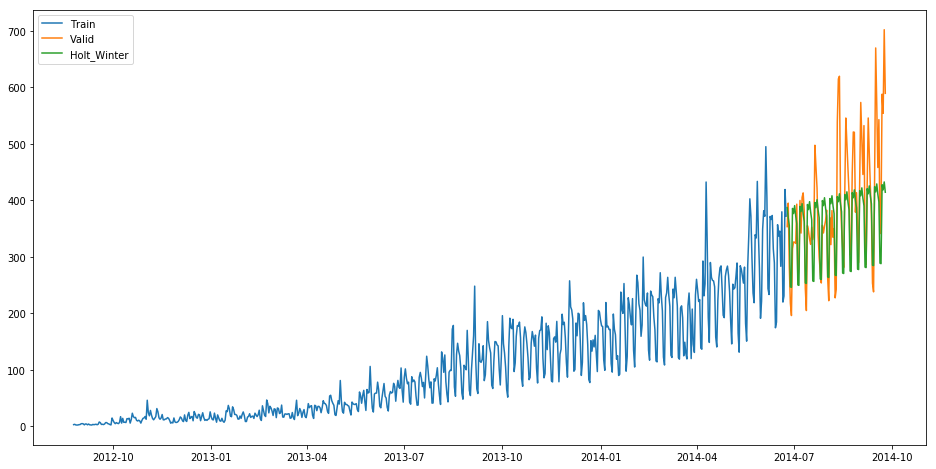

RMSE =  82.37468333517167


In [23]:
y_hat_avg = valid.copy()
fit1= ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize = (16,8))
plt.plot(Train['Count'], label= 'Train' )
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt_Winter')
plt.legend()
plt.show()
print('RMSE = ', sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)))

We see that the rmse value has reduced a lot from this method. Let's forecast the Counts for the test dataset

In [24]:
predict = fit1.forecast(len(test))
test['predict'] = predict
test.head()

,ID,year,month,day,Hour,predict
Datetime,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,387.359742
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,369.136021
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,355.562678
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,247.090124
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,246.193771


But these predictions are daily predcitions. To convert these to hourly basis we need to calculate the ratio of passenger count fro each hour of the day. We calculate the ratio for each hour in our original train dataset and multiply it to the daily predcitioins to find the hourly predictions.

In [25]:
#calculating the hourly ratio of the count
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()

#Grouping the houry ratio
temp = train_original.groupby(['Hour'])['ratio'].sum()

# To change temp to csv format
pd.DataFrame(temp, columns= ['Hour', 'ratio']).to_csv('GROUPby.csv')
temp2  = pd.read_csv('GROUPby.csv')
temp2.head()

temp2 = temp2.drop('Hour.1',1)
temp2.head()

,Hour,ratio
0,0.0,0.001521
1,1.0,0.001269
2,2.0,0.001114
3,3.0,0.000906
4,4.0,0.000765


In [26]:
#Merging Test and test_original on day , month and year
merge = pd.merge(test, test_original, on = ('day', 'month', 'year'), how = 'left')
merge['Hour'] = merge ['Hour_y']
merge = merge.drop(['year', 'month', 'Datetime','Hour_x', 'Hour_y'], axis = 1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting Ratio to original Scale
prediction['Count'] = prediction['predict']*prediction['ratio']*24
prediction['ID'] = prediction['ID_y']
prediction = prediction.drop(['ID_x', 'ID_y', 'day', 'predict', 'Hour', 'ratio'], 1)
test.shape


(213, 6)

Holt's Linear model took care of the trend while the Holt's Winter model took care of seasonality. Now we come to ARIMA, which takes care of both seasonality and trend.<br> <br> 
**5) ARIMA**<br>
ARIMA Stands for Auto Regression Integrated Moving Average and it is specified by 3 Ordered Parameters (p,d,q).<br>
p is the order of the autoregressive model(number of time lags) <br>
d is the degree of differencing(number of times the data have had past values subtracted)<br>
q is the order of moving average model. We will discuss more about these parameters in next section.<br>
<br>
For ARIMA model, the time series should be stationary that is, the mean , variance and covariance must be independent of time.
<br>
We use *dickey fullar* test to check for stationarity and if the Test statistic is less than the critical value we reject the null hypothesis that the time series is not stationary.


In [27]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):        #Function to calculate the results of the Dickey-Fuller test.
    
    #Determining rolling Statistics for 24 hours on each day
    rolmean = pd.rolling_mean(timeseries, window= 24)    
    rolstd = pd.rolling_std(timeseries, window = 24)
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color = blue, label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block= False)
    
    # Dickey-Fuller Test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfdoutput)

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

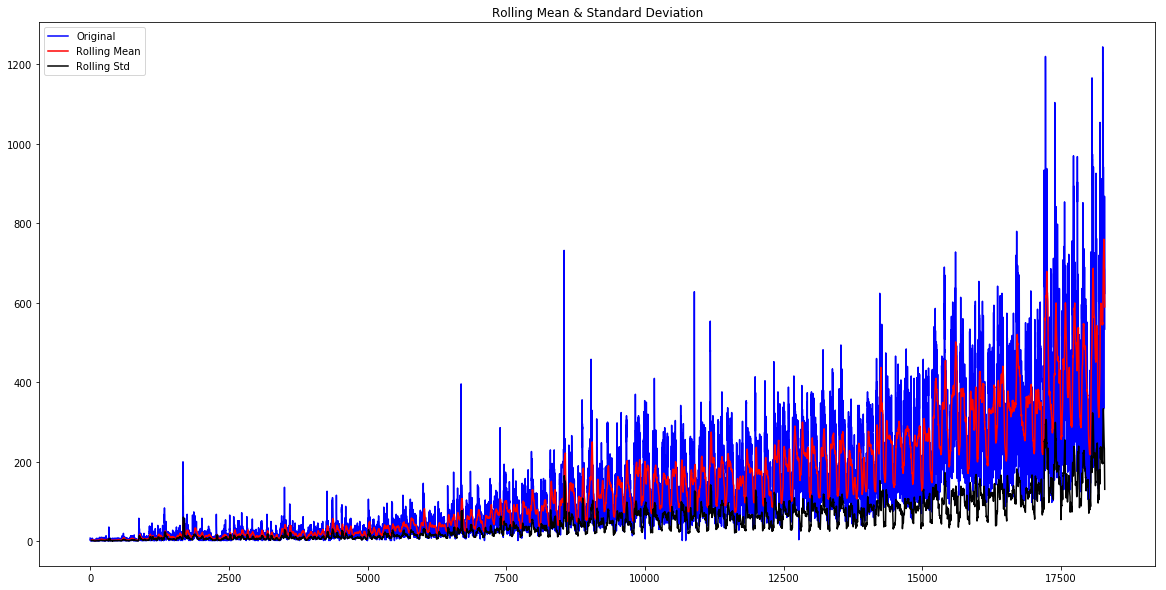

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

test_stationarity(train_original['Count'])

The results show that the time series is stationary as  Test statistic is less than the critical values. However, we see that there is an increasing trend in the data. So, firstly we will try to make data more stationary by removing the trend.<br>
We see aa increasing trend in the data so we can apply transformation that penalizes higher values more than the smaller ones.

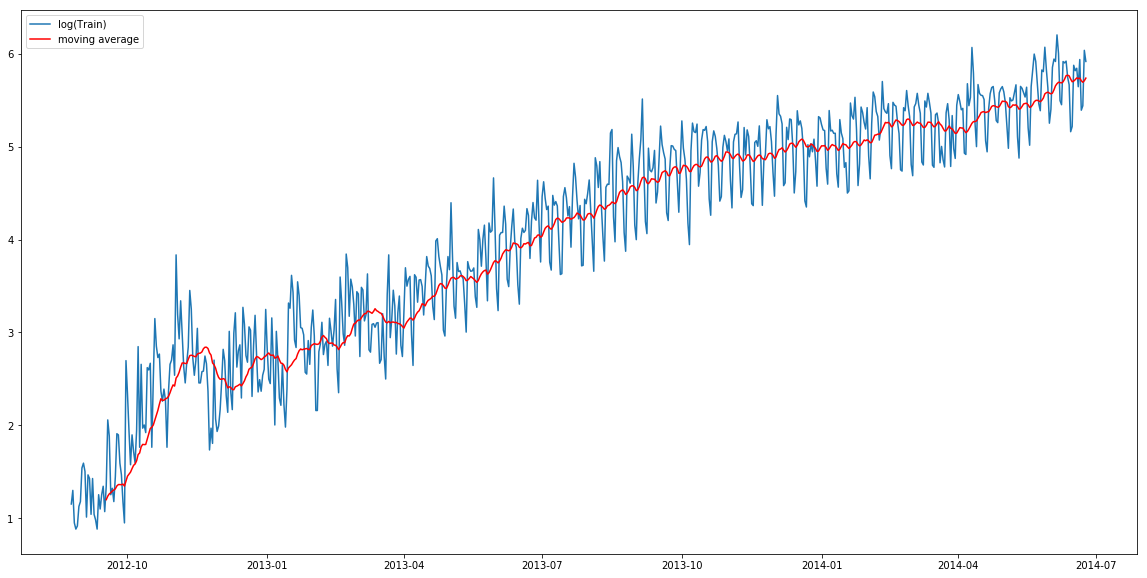

In [35]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log, label = 'log(Train)')
plt.plot(moving_avg, color = 'R', label = 'moving average')
plt.legend()
plt.show()

The trend is clearly visible from the red line of the moving average. We remove it by subtracting is from the Train_log

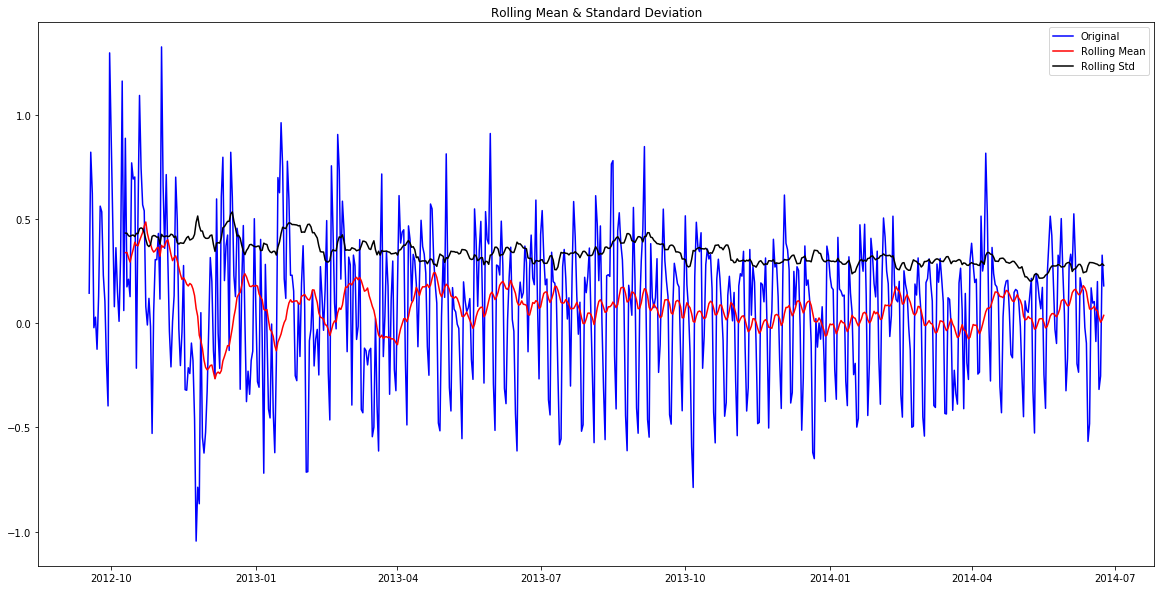

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [38]:
train_log_moving_avg_diff = Train_log - moving_avg

train_log_moving_avg_diff.dropna(inplace = True)    # Dropping Null Values 

test_stationarity(train_log_moving_avg_diff)

The test statistic is now even smaller as the trend has been removed. We now statbilize the mean as is should not be a function of time.

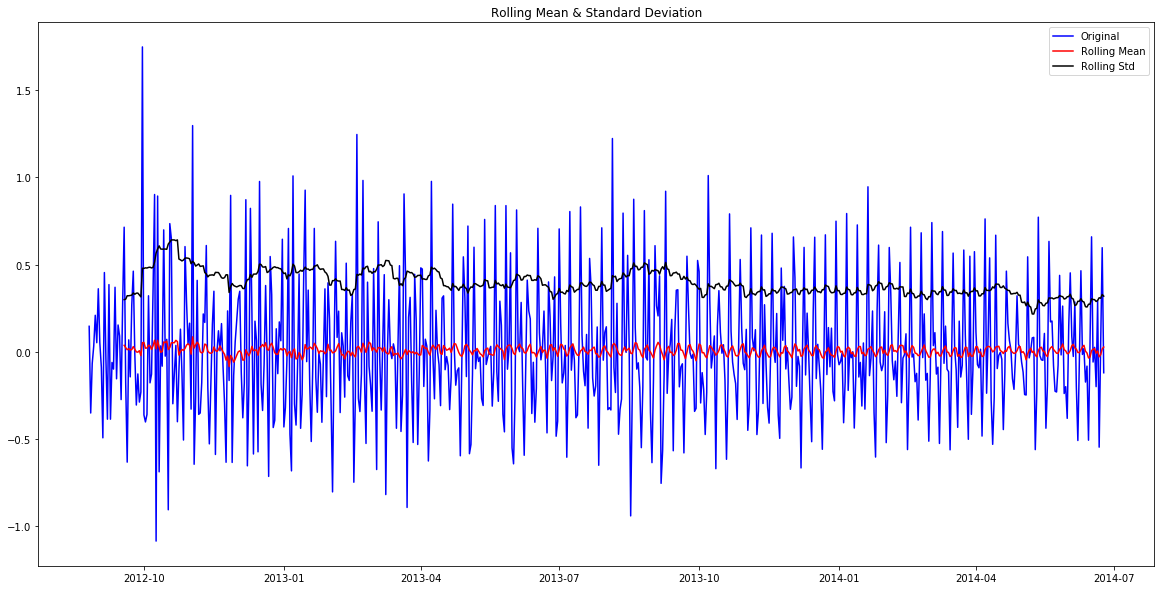

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [40]:
train_log_diff = Train_log  - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

**Removing Seasonality** <br>
Seasonality means periodic fluctuctions of a fixed and known period. We use seasonal_decompose to decompose time series into trend, seasonality and residuals.


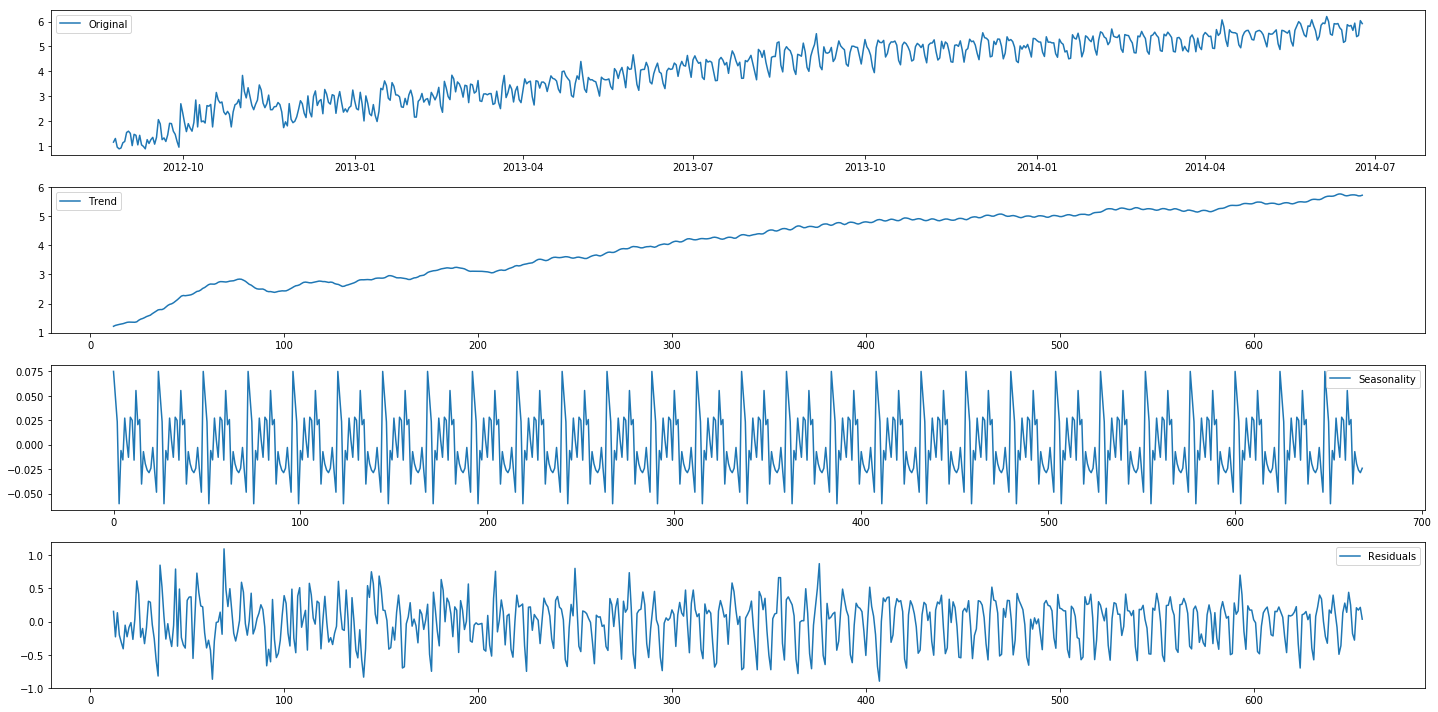

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label = 'Original')
plt.legend()
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We find the values of p,d,q parameters required for applying ARIMA algortihm. To find the optimized values of these parameters we use ACF and PACF.<br>
ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.<br> 
PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

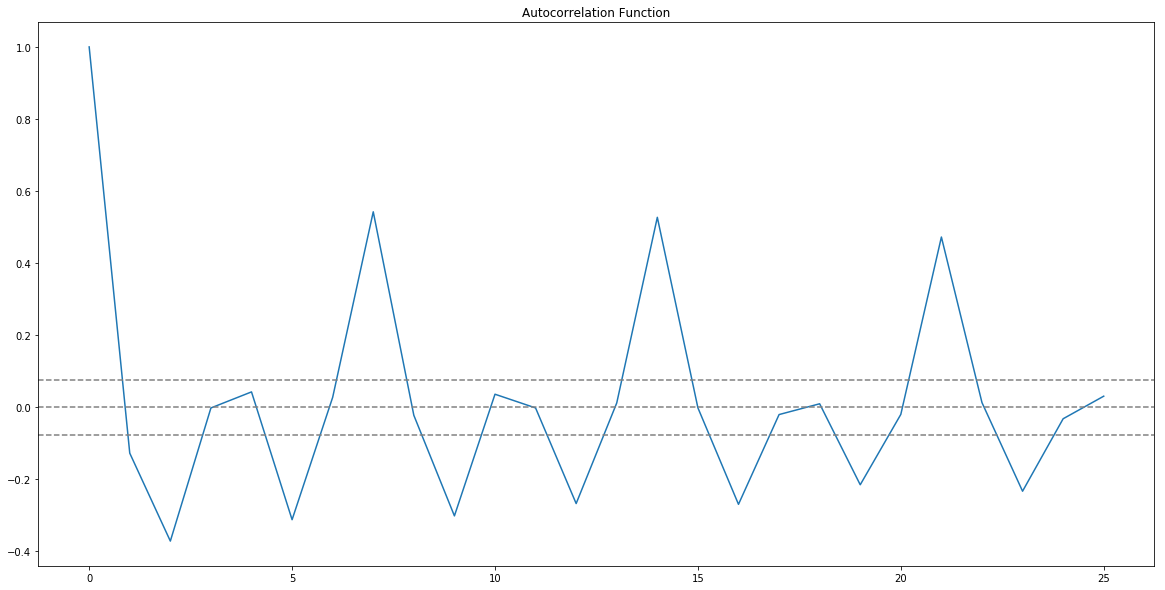

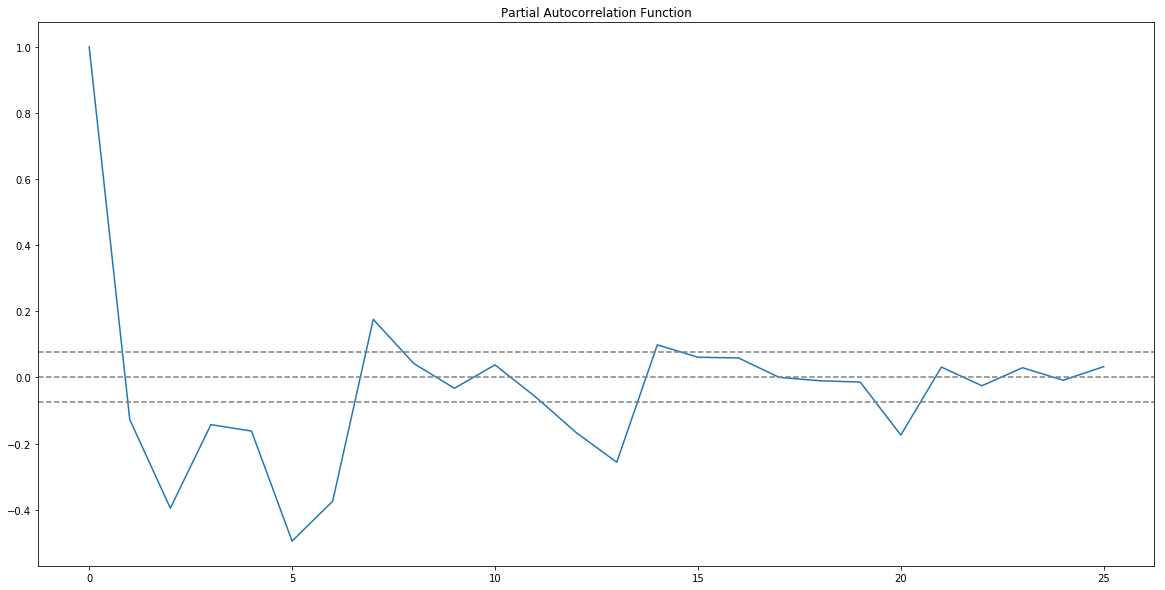

In [54]:
from statsmodels.tsa.stattools import acf,pacf
lag_acf = acf(train_log_diff.dropna(), nlags= 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method = 'ols')

plt.plot(lag_acf)
plt.axhline(y = 0, linestyle ='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time . Here p = 1. <br>
q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. Here q = 1


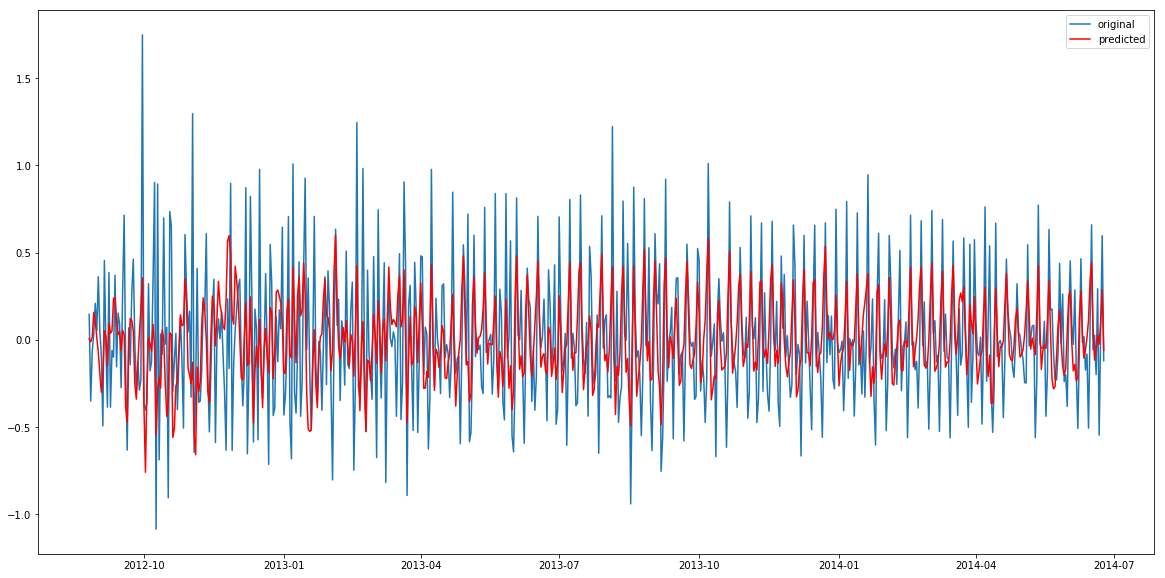

In [64]:
#ARIMA model 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

In [65]:
# function to change the scale of the model to the current scale
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [ ]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()
    
    

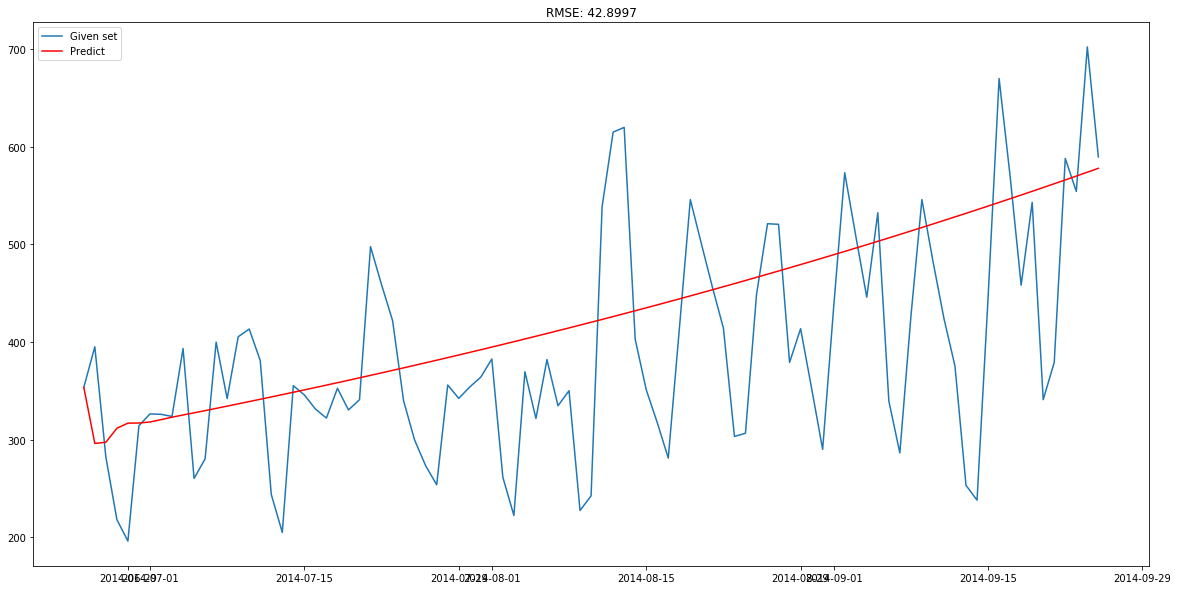

In [66]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)